<a href="https://colab.research.google.com/github/mostafa-ja/mal_adv3/blob/main/2_DNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from scipy import sparse
import gdown
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc

In [ ]:
download_link = 'https://drive.google.com/uc?id=12iud4h19CZst4exbr3U2A9iDxBYvZ5U_'
output_filepath = '/content/'
gdown.download(download_link, output_filepath)

Downloading...
From: https://drive.google.com/uc?id=12iud4h19CZst4exbr3U2A9iDxBYvZ5U_
To: /content/X_redefined_sparse_matrix.npz
100%|██████████| 2.31M/2.31M [00:00<00:00, 35.8MB/s]


'/content/X_redefined_sparse_matrix.npz'

In [ ]:
download_link = 'https://drive.google.com/uc?id=1IhrcT3jHqlPrw2KvQ5vJkBgozxcJ1cJm'
output_filepath = '/content/'
gdown.download(download_link, output_filepath)

Downloading...
From: https://drive.google.com/uc?id=1IhrcT3jHqlPrw2KvQ5vJkBgozxcJ1cJm
To: /content/labels.pt
100%|██████████| 517k/517k [00:00<00:00, 86.9MB/s]


'/content/labels.pt'

In [ ]:
# Load dataset
X_redefined = sparse.load_npz("X_redefined_sparse_matrix.npz")
labels_tensor = torch.load('labels.pt')

In [ ]:
# Split data into train, validation, and test sets with stratified sampling
X_train_val, X_test, labels_train_val, labels_test = train_test_split(X_redefined, labels_tensor, test_size=0.2, stratify=labels_tensor, random_state=42)
X_train, X_val, labels_train, labels_val = train_test_split(X_train_val, labels_train_val, test_size=0.2, stratify=labels_train_val, random_state=42)

# Combine features and labels into datasets
train_dataset = TensorDataset(torch.tensor(X_train.toarray(), dtype=torch.float32), labels_train)
val_dataset = TensorDataset(torch.tensor(X_val.toarray(), dtype=torch.float32), labels_val)
test_dataset = TensorDataset(torch.tensor(X_test.toarray(), dtype=torch.float32), labels_test)


In [ ]:
# Define the DataLoader for training, validation, and test sets
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
import torch
import torch.nn as nn

class MalwareDetectionModel(nn.Module):
    def __init__(self, input_size=10000, hidden_1_size=200, hidden_2_size=200, num_labels=2, dropout_prob=0.6):
        super(MalwareDetectionModel, self).__init__()

        self.input_size = input_size
        self.hidden_1_size = hidden_1_size
        self.hidden_2_size = hidden_2_size
        self.num_labels = num_labels
        self.dropout_prob = dropout_prob

        self.fc1 = nn.Linear(input_size, hidden_1_size)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_1_size, hidden_2_size)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_prob)
        self.fc3 = nn.Linear(hidden_2_size, num_labels)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.log_softmax(x)
        return x


In [ ]:
model = MalwareDetectionModel()

# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs=8

# Training Loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = model(inputs)
        loss = criterion(outputs, labels.view(-1).long())
        loss.backward()  # Backward pass
        optimizer.step()  # Update parameters

    #  Validation
    model.eval()  # Set model to evaluation mode
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            _, predicted = torch.topk(outputs, k=1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()

    validation_accuracy = total_correct / total_samples
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Accuracy: {validation_accuracy:.4f}')


Epoch [1/8], Validation Accuracy: 0.9916
Epoch [2/8], Validation Accuracy: 0.9934
Epoch [3/8], Validation Accuracy: 0.9935
Epoch [4/8], Validation Accuracy: 0.9941
Epoch [5/8], Validation Accuracy: 0.9944
Epoch [6/8], Validation Accuracy: 0.9950
Epoch [7/8], Validation Accuracy: 0.9953
Epoch [8/8], Validation Accuracy: 0.9948


In [ ]:
# Save model parameters
torch.save(model.state_dict(), 'DNN_params.pth')

In [ ]:
# Evaluate the trained model on the test set
model.eval()  # Set the model to evaluation mode
predictions = []
true_labels = []

with torch.no_grad():
    for X_batch, labels_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.topk(outputs, k=1)
        predictions.extend(predicted.tolist())
        true_labels.extend(labels_batch.tolist())

# Convert predictions and true labels to numpy arrays
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Calculate test accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f'Test Accuracy: {accuracy:.4f}')

# Calculate precision, recall, and F1-score
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')


Test Accuracy: 0.9934
Precision: 0.9654
Recall: 0.8786
F1-score: 0.9200


In [ ]:
# Calculate true positives, true negatives, false positives, and false negatives
TP = ((predictions == 1) & (true_labels == 1)).sum()
TN = ((predictions == 0) & (true_labels == 0)).sum()
FP = ((predictions == 1) & (true_labels == 0)).sum()
FN = ((predictions == 0) & (true_labels == 1)).sum()

print(f'True Positives (TP): {TP}')
print(f'True Negatives (TN): {TN}')
print(f'False Positives (FP): {FP}')
print(f'False Negatives (FN): {FN}')


True Positives (TP): 977
True Negatives (TN): 24656
False Positives (FP): 35
False Negatives (FN): 135


In [ ]:
#here , we define prediction, as probability(not binary)

# Evaluate the trained model on the test set
model.eval()  # Set the model to evaluation mode
predictions = []
true_labels = []

with torch.no_grad():
    for X_batch, labels_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.topk(outputs, k=1)
        predictions.extend(predicted.tolist())
        true_labels.extend(labels_batch.tolist())

# Convert predictions and true labels to numpy arrays
predictions = np.array(predictions)
true_labels = np.array(true_labels)


# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(true_labels, predictions)

# Calculate F1-score for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)

# Find the threshold that maximizes the F1-score
best_f1_threshold = thresholds[np.argmax(f1_scores)]
best_f1_score = np.max(f1_scores)

print(f'Best F1-score: {best_f1_score:.4f} at threshold: {best_f1_threshold:.4f}')


Best F1-score: 0.9200 at threshold: 1.0000


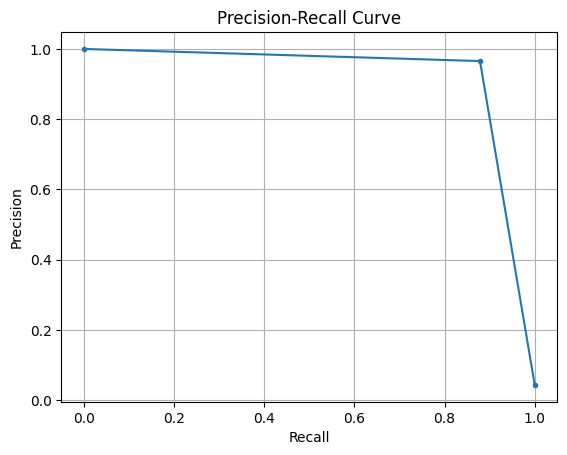

In [ ]:

# Calculate precision and recall
precision, recall, _ = precision_recall_curve(true_labels, predictions)

# Plot precision-recall curve
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()


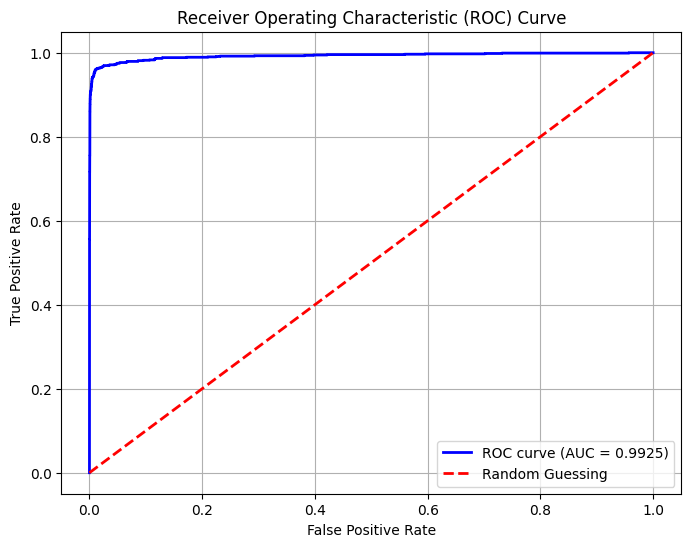

In [ ]:
# Compute fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(true_labels, predictions)

# Compute AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()